# Modelling CONCAT
- This notebook uses the data obtained from Pre-Processing notebook

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import multiprocessing as mp
import re
import pickle
import time
import random
import matplotlib.pyplot as plt

In [2]:
# Random Seed for Reproducibility
tf.keras.utils.set_random_seed(442)

In [3]:
# GPU Usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Set memory growth
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

Num GPUs Available:  1


2022-05-29 19:23:42.150481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 19:23:42.158005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 19:23:42.158131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
labeldict = {
    'Sadness': 0,
    'Excited': 1,
    'Happiness': 2,
    'Anger' : 3,
    'Frustration' : 4,
    'Other' : 5
}

In [5]:
def one_hot_encode(label):
    one_hot = np.zeros(6)
    one_hot[labeldict[label]] = 1
    return one_hot

In [6]:
def one_hot_encode_list(listOfLabels):
    finalList = []
    for label in listOfLabels:
        finalList.append(one_hot_encode(label))
    return np.array(finalList)

In [7]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [8]:
def get_mel_and_label(path):
    emotion = re.match('.*/DATA/([a-zA-Z]+)/.*', path).groups()[0]
    data, _ = librosa.load(path, sr=44100)
    mels = librosa.feature.melspectrogram(y=data, sr=44100, n_mels=256)
    # min-max scale 
    img = scale_minmax(mels, 0, 255)
    return img, emotion

In [9]:
def preprocess_input(pathList): # Returns a list of x (batch_size, timesteps, feature), y (one_hot_encoded)
    with mp.Pool() as p:
        results = p.map(get_mel_and_label, pathList)
    # Preprocess x:
    x = [item[0] for item in results]
    # Convert to tensor
    x = [tf.convert_to_tensor(sublist) for sublist in x]
    # Resizing and zero-padding     # VGG19 takes input of shape (224, 224, 3)
    x = [tf.image.resize_with_pad(tf.reshape(item, shape=(256, -1, 1)), target_height=224, target_width=224) for item in x]
    x = tf.convert_to_tensor(x, dtype=tf.float16) # Float 16 is faster
    # Preprocess y:
    y = [item[1] for item in results]
    # one_hot_encode
    y = one_hot_encode_list(y)
    return x, y

# Loading data: 
- We will load the data per predefined batch size, this is to reduce the memory used for training:

In [10]:
with open('train_paths.pkl', 'rb') as f:
    train_paths = pickle.load(f)
with open('test_paths.pkl', 'rb') as f:
    test_paths = pickle.load(f)

In [11]:
# Make batches of the pathList:
def create_batches(pathList, batch_size):
    ansList = [] # To store the final batched paths
    tempList = [] # Temporary list
    count = 0
    while count < len(pathList):
        tempList.append(pathList[count]) # Append the path
        count += 1
        if (count % batch_size) == 0: # if count is a multiple of batch_size
            ansList.append(tempList)
            tempList = []
    if len(tempList) != 0: # If tempList is not empty
        ansList.append(tempList) # Append the remaining values
    return ansList

In [12]:
a, b = preprocess_input(train_paths[0:2])

2022-05-29 19:23:44.681917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-29 19:23:44.683060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 19:23:44.683214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 19:23:44.683276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

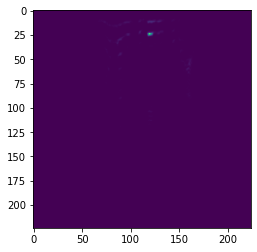

In [13]:

plt.imshow(a[1])

# Modelling:

In [14]:
# Call vgg
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(weights='imagenet', include_top=False)

In [15]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [16]:
# freeze the layers:
for layer in vgg.layers[:10]:
    layer.trainable = False

In [17]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [18]:
# Keras API:
img_input = tf.keras.layers.Input(shape=(224, 224,1))
# For three channels: https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])
image = tf.keras.applications.vgg16.preprocess_input(img_conc)
vgg_out = vgg(image)
x = layers.Flatten()(vgg_out) # Flatten the output of VGG
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(6, activation='softmax')(x)

model = keras.Model(img_input, x)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 224, 224, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['concatenate[0][0]']        

# Training the model

In [20]:
# Batch_size is 32, epochs = 30
batch_size = 32
epochs = 30

In [21]:
# Optimizer is Stochastic Gradient Descent
# Loss function is Categorical Crossentropy
optimizer = keras.optimizers.Adam() #amsgrad=True
loss_fn = keras.losses.CategoricalCrossentropy()

In [22]:
training_batch = create_batches(train_paths, batch_size=batch_size)
validation_batch = create_batches(test_paths, batch_size=batch_size)

In [23]:
# Metrics:
train_metrics = tf.keras.metrics.CategoricalAccuracy()
validation_metrics = tf.keras.metrics.CategoricalAccuracy()
train_loss = tf.keras.metrics.CategoricalCrossentropy()
validation_loss = tf.keras.metrics.CategoricalCrossentropy()

In [24]:
# A list to store epoch results:
epoch_accuracy_train = []
epoch_accuracy_val = []
epoch_loss_train = []
epoch_loss_val = []

In [25]:
# To speed up, use graph execution
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training = True)
        loss = loss_fn(y, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Update training accuracy
    train_metrics.update_state(y, y_pred)
    # Update training loss:
    train_loss.update_state(y, y_pred)
    return loss

In [26]:
@tf.function
def valid_step(x, y):
    y_val_pred = model(x, training=False)
    # Update metrics for validation
    validation_metrics.update_state(y, y_val_pred)
    validation_loss.update_state(y, y_val_pred)
    return

In [ ]:
# Custom Training loop:
for epoch in range(epochs):
    start_time = time.time()
    print("\nStart of epoch %d" % (epoch))
    # Shuffle the training batch for each epoch:
    random.shuffle(training_batch)
    for step, batch in enumerate(training_batch):
        x, y = preprocess_input(batch)
        
        loss = train_step(x, y)
        
        # Log every 200 batches.
        if step % 10 == 0 and step != 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
    
    # Display metrics at the end of each epoch.
    train_acc = train_metrics.result()
    print("Training acc over epoch: %.4f" % (float(train_acc)))
    loss_train = train_loss.result()
    print("Training loss over epoch: %.4f" % (float(loss_train)))
    
    # Reset training metrics at the end of each epoch
    train_metrics.reset_states()
    train_loss.reset_states()
    
    # For validation data:
    for val_batch in validation_batch:
        x_val, y_val = preprocess_input(val_batch)
        
        valid_step(x_val, y_val)
        

    # Metrics
    val_acc = validation_metrics.result()
    loss_val = validation_loss.result()
    validation_metrics.reset_states()
    validation_loss.reset_states()
    
    # Append to a list for graph:
    epoch_accuracy_train.append(train_acc)
    epoch_accuracy_val.append(val_acc)
    epoch_loss_train.append(loss_train)
    epoch_loss_val.append(loss_val)
    
    print("Validation acc: %.4f" % (float(val_acc)))
    print("Validation loss: %.4f" % (float(loss_val)))
    print("Time taken: %.2fs" % (time.time() - start_time))



Start of epoch 0


2022-05-29 19:23:58.591273: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-05-29 19:24:00.822982: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-05-29 19:24:01.556162: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


Training loss (for one batch) at step 10: 1.8215
Seen so far: 352 samples
Training loss (for one batch) at step 20: 1.7939
Seen so far: 672 samples
Training loss (for one batch) at step 30: 1.7900
Seen so far: 992 samples
Training loss (for one batch) at step 40: 1.7958
Seen so far: 1312 samples
Training loss (for one batch) at step 50: 1.7922
Seen so far: 1632 samples
Training loss (for one batch) at step 60: 1.7886
Seen so far: 1952 samples
Training loss (for one batch) at step 70: 1.7940
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 1.7917
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.7921
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 1.7904
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 1.7904
Seen so far: 3552 samples
Training loss (for one batch) at step 120: 1.7915
Seen so far: 3872 samples
Training loss (for one batch) at step 130: 1.7919
Seen so far: 4192 samples
Training loss (for one b

Process ForkPoolWorker-12223:
Exception ignored in: <function _releaseLock at 0x7f24108f8a60>
Traceback (most recent call last):
  File "/home/tyson/anaconda3/envs/dl/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process ForkPoolWorker-12224:
Process ForkPoolWorker-12222:
Process ForkPoolWorker-12221:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tyson/anaconda3/envs/dl/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/tyson/anaconda3/envs/dl/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tyson/anaconda3/envs/dl/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/tyson/anaconda3/envs/dl/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  Fi

# Plotting:

In [21]:
import matplotlib.pyplot as plt

In [22]:
axis_x = [i+1 for i in range(epochs)]

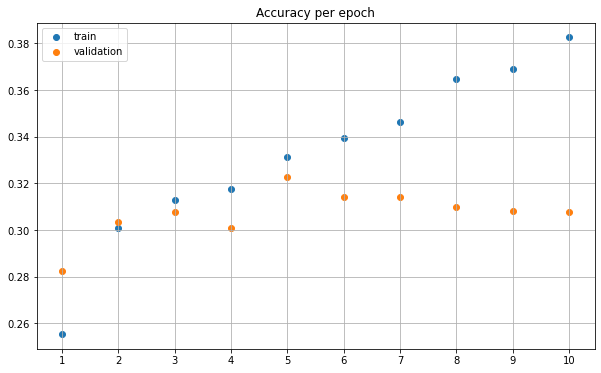

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x = axis_x, y = epoch_accuracy_train, label = "train")
ax.scatter(x = axis_x, y = epoch_accuracy_val, label="validation")
ax.legend()
ax.grid()
ax.set_title("Accuracy per epoch")
ax.set_xticks(ticks = axis_x)
plt.show()

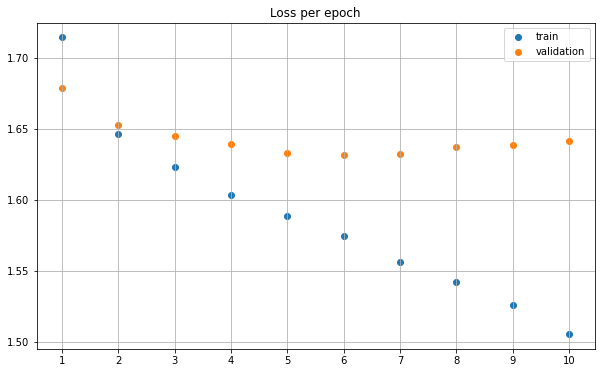

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = axis_x, y = epoch_loss_train, label="train")
ax.scatter(x = axis_x, y = epoch_loss_val, label="validation")
ax.legend()
ax.grid()
ax.set_title("Loss per epoch")
ax.set_xticks(ticks = axis_x)
plt.show()